In [1]:
import sys

sys.path.append('.')

import model

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import seaborn as sns

# COVID Contract Tracing on a Graph

This notebook adapts the COVID spreading and contact tracing model from our NetLogo implementation to one where the contact network structure can be explicitly and generically defined.

## Model definition

### State Space

In this model, the individuals are either **Susceptible**, **Exposed**, **Infectious**, or **Recovered** (or Removed). In the following equations, we use $S$, $E$, $I$, and $R$ to denote the number of individuals in each compartment and $N$ to denote the total population. Individuals may also be **Symptomatic** ($M$).

Individuals may also be **Adopters** ($A$) of a notionally smartphone-based contact tracing system, and/or **Quarantined** ($Q$). There is also a flag for each indiviudal, **Tested**, which is true only if the individual has already been tested this time step.

The spatial and social connections between individuals are modeled using an **Adjacency Graph**, a weighted, undirected graph. Each individual is a node on the graph. An edge between two nodes indicates a non-zero probability of the individuals contacting each other. The weight on the edge is the strength (probability) of contact. Contacts determine the spread of the disease as well as the activation of the contact tracing system.

Individuals will also keeps a **Contact List**. This is a list of other individuals that have contacted them, with a time stamp. (Equivalently, this can be thought of as a master list owned by the contact tracing system of past contacts.) When the contact tracing system is invoked, only contacts up to the last **Memory Limit** time steps are used.

`There is a variable idea of **Tracing Logic**. This is a property of the contact tracing system. It specifies both, or just one (and if so which) individuals must be adopters of the system in order for their phones to register a contact. By default, *both individuals* must be adopters for a contact to be traced.`


### Parameters

There are a number of free parameters. These parameterizations can be varied in many ways: by sampling them from multivariate distributions, for example. This is just a simple way of setting thins up:

* $W$ - the weight on each edge, the probability of the edge being activated
* $A$ - the probability of adopting the contact tracing system
* $\hat{\beta}$ - the probability of transmission from infectious to susceptible given an active contact
* $\alpha$ - probability of an *Exposed* person becoming *Infectious*.
* $\gamma$ - probability of an *Infectious* person becoming *Recovered*.
* $\zeta$ - probability of an *Infectious* person becoming *Symptomatic*
* $L$ - the memory limit of the contact tracing system


### The Setup

The individual's are "arranged" according to the *Adjacency Graph*.

The individuals are assigned as *Adopters* or *Non-Adopters* exogenously.

The individuals all begin as *Susceptible*, except for a (small) number of *Indices*, who begin as Infected.

### The Narrative

At each time step $t$, a series of operations takes place over the simulated population.

1. Each edge of the graph $e_{i,j}$ becomes *active*:
  * On the condition that neither $i$ nor $j$ is *Quarantined*.
  * With probability $w(e_{i,j}$ (the edge weight).

2. For each active edge $e_{i,j}$:
  * The contact between $i$ and $j$ is traced if $T(a(i),a(j)$, and vice versa, where $T$ is the tracing logic and $a$ is whether or not an individual is an adopter.
  * If $i$ is *Infectious* and $j$ is *Susceptible*, then $j$ becomes *Exposed* with probability $\hat{\beta}$. `[Note: This could become \beta_i in a more complex model.]` And vice versa.
  
3. For each individual $i$:
  * If the individual is *Exposed*, become *Infectious* with probability $\alpha$.
  * If the individual is *Infectious*, become *Recovered* with probability $\gamma$
  
4. For each individual $i$, who is *Infectious*:
  * Become *Symptomatic* with probability $\zeta$. *If* $i$ becomes symptomatic, call subroutine: $GetTested(i)$
  
  
There is a subroutine, $GetTested$, that can be called on an individual $i$. It is called a subroutine because it is part of the narrative the occurs recursively.

When $GetTested$ is called on an agent $i$:

1. If the agent has already been tested, stop immediately.

2. If the agent has not already been tested, then:
  * Set Tested(i) to True.
  * If the agent is *Susceptible* or *Recovered*, then the agent tests negative. Do nothing.
  * If the agent is *Exposed* or *Infectious*, then the agent tests positive. In this case:
    * Set the agent to *Quarantined*
    * For all contacts $j$ of $i$ up to *Memory Limit* time steps ago:
       * $GetTested(j)$
       
At the end of each time step, set *Tested* to false for all agents.

## Building the Model

### Setting the Parameters

### Initializing the Model

There's a lot of interesting work on synthetic social graph generation:

 * https://www.researchgate.net/publication/307904341_Generating_Scaled_Replicas_of_Real-World_Complex_Networks
 * https://faculty.nps.edu/rgera/MA4404/Winter2017/03-SyntheticModelsComplexNetworks.pdf
 * https://pdfs.semanticscholar.org/ca70/aca47d8fe8a604e1a9af0eae22c6604f8407.pdf

#### Building the adjacency graph

We will start with square lattice for now.

In [3]:
# Build the graph

# Square Lattice
#gl = nx.grid_2d_graph(50,50,periodic=False)

g = nx.watts_strogatz_graph(2500, 8, .02)

#g = g.subgraph(max(nx.connected_components(g))).copy()

In [4]:
(len(g.nodes()), len(g.edges()))

(2500, 10000)

In [5]:
W = len(g.nodes()) / len(g.edges())
print(W)

0.25


In [6]:


## Population parameters:
params = {

    'W' : W, # probability of edge activation
    'A' : .8, # probability of adoption

    ## Disease parameters

    'beta_hat' : 1, # probability of transmission upon contact
    'alpha' : .25, # probability of exposed becoming infectious
    'gamma' : .1, # probability of infectious becoming recovered
    'zeta' : .1, # probability of infectious becoming symptomatic

    ## Contact tracing parameters

    'limit' : 10, # number of time steps the contact tracing system remembers
}

# Simulation state variables

t : 0 # discrete time!

In [7]:
params_low_adoption = params.copy()
params_low_adoption['A'] = .3

params_low_limit = params.copy()
params_low_limit['limit'] = 3

conditions = {
    'control' : params,
    'low adoption' : params_low_adoption,
    'low memory' : params_low_limit
}

#### Set edge weights


#### Set adoption, quarantine, and tested states

`adopter` is True if an adopter, False otherwise. Adoption is probabilistic, drawn from $Bernoulli(A)$.

#### Set adoption, quarantine, and tested states

All agents start not quarantined and not tested.

#### Set the infectious index and the rest to susceptible epi-states

In [8]:
model.initialize(g, params)

#### What does it look like?

A visualization. Note all individuals are susceptible except for the red ones, which are infectious. Adopters are cyan; non-adopters are black.

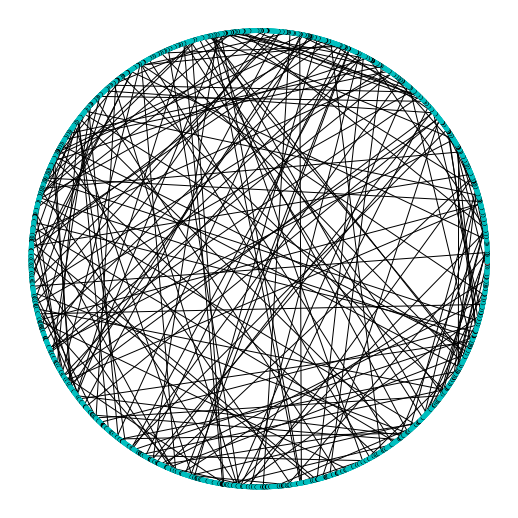

In [9]:
plt.figure(3,figsize=(7,7)) 
## draw_spectral for the lattice
nx.draw_circular(g,
                node_size = 15,
                node_color = [
                    'r'
                    if n[1]['epi-state'] == 'Infectious'
                    else 'c'
                    if n[1]['adopter']
                    else 'k'
                    for n
                    in g.nodes(data=True)
                ])

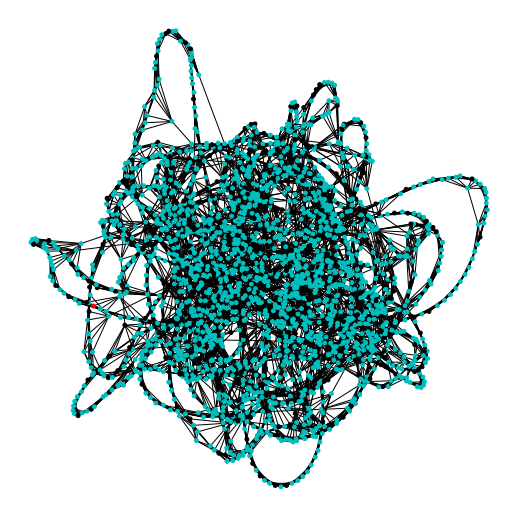

In [10]:
plt.figure(3,figsize=(7,7)) 
## draw_spectral for the lattice
nx.draw_spring(g,
                node_size = 15,
                node_color = [
                    'r'
                    if n[1]['epi-state'] == 'Infectious'
                    else 'c'
                    if n[1]['adopter']
                    else 'k'
                    for n
                    in g.nodes(data=True)
                ])

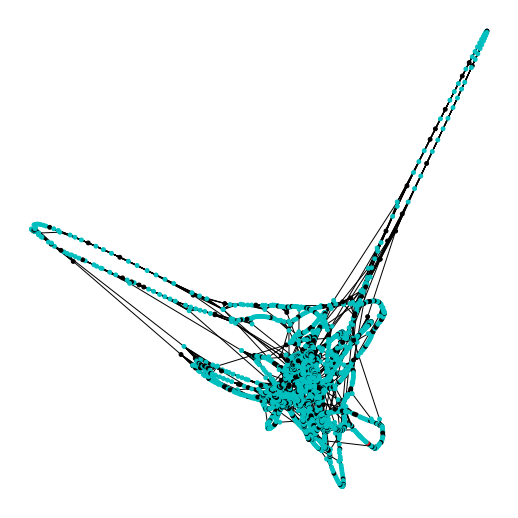

In [11]:
plt.figure(3,figsize=(7,7)) 
## draw_spectral for the lattice
nx.draw_spectral(g,
                node_size = 15,
                node_color = [
                    'r'
                    if n[1]['epi-state'] == 'Infectious'
                    else 'c'
                    if n[1]['adopter']
                    else 'k'
                    for n
                    in g.nodes(data=True)
                ])

### Defining the Simulation Procedures

At each time step $t$, a series of operations takes place over the simulated population...

#### Choose the activated edges


1. Each edge of the graph $e_{i,j}$ becomes *active*:
  * On the condition that neither $i$ nor $j$ is *Quarantined*.
  * With probability $w(e_{i,j}$ (the edge weight).

In [12]:
e = g.edges().__iter__().__next__()

In [13]:
g.nodes[e[0]]

{'adopter': True,
 'quarantined': False,
 'symptomatic': False,
 'tested': False,
 'epi-state': 'Susceptible'}

In [14]:
model.active_edges(g)[:5]

[(0, 2498, {'w': 0.25}),
 (0, 3, {'w': 0.25}),
 (0, 2497, {'w': 0.25}),
 (1, 2498, {'w': 0.25}),
 (2, 4, {'w': 0.25})]

#### Trace and infect along active edge

 For each active edge $e_{i,j}$:
  * The contact between $i$ and $j$ is traced if $T(a(i),a(j)$, and vice versa, where $T$ is the tracing logic and $a$ is whether or not an individual is an adopter.
  * If $i$ is *Infectious* and $j$ is *Susceptible*, then $j$ becomes *Exposed* with probability $\hat{\beta}$. `[Note: This could become \beta_i in a more complex model.]` And vice versa.

#### Disease progression

For each individual $i$:
  * If the individual is *Exposed*, become *Infectious* with probability $\alpha$.
  * If the individual is *Infectious*, become *Recovered* with probability $\gamma$

#### Become symptomatic and getting tested

For each individual $i$, who is *Infectious*:
  * Become *Symptomatic* with probability $\zeta$. *If* $i$ becomes symptomatic, call subroutine: $GetTested(i)$
  
  
There is a subroutine, $GetTested$, that can be called on an individual $i$. It is called a subroutine because it is part of the narrative the occurs recursively.

When $GetTested$ is called on an agent $i$:

1. If the agent has already been tested, stop immediately.

2. If the agent has not already been tested, then:
  * Set Tested(i) to True.
  * If the agent is *Susceptible* or *Recovered*, then the agent tests negative. Do nothing.
  * If the agent is *Exposed* or *Infectious*, then the agent tests positive. In this case:
    * Set the agent to *Quarantined*
    * For all contacts $j$ of $i$ up to *Memory Limit* time steps ago:
       * $GetTested(j)$

#### End of loop  
       
At the end of each time step, set *Tested* to false for all agents.

## Running the model

In [15]:
model.get_infected(g)

[(2493,
  {'adopter': True,
   'quarantined': False,
   'symptomatic': False,
   'tested': False,
   'epi-state': 'Infectious'})]

In [16]:
#records = model.simulate_sample(g, params, 50)

runs = 50

results = model.experiment(
    g,
    conditions,
    runs)

records = results['control']

control
Trial 0
Trial 44 hits time step 100
low adoption
Trial 0
Trial 0 hits time step 100
Trial 1 hits time step 100
Trial 1 hits time step 200
Trial 2 hits time step 100
Trial 2 hits time step 200
Trial 3 hits time step 100
Trial 3 hits time step 200
Trial 4 hits time step 100
Trial 4 hits time step 200
Trial 5 hits time step 100
Trial 5 hits time step 200
Trial 6 hits time step 100
Trial 8 hits time step 100
Trial 8 hits time step 200
Trial 8 hits time step 300
Trial 9 hits time step 100
Trial 9 hits time step 200
Trial 10 hits time step 100
Trial 10 hits time step 200
Trial 11 hits time step 100
Trial 11 hits time step 200
Trial 14 hits time step 100
Trial 14 hits time step 200
Trial 15 hits time step 100
Trial 15 hits time step 200
Trial 15 hits time step 300
Trial 16 hits time step 100
Trial 16 hits time step 200
Trial 17 hits time step 100
Trial 17 hits time step 200
Trial 18 hits time step 100
Trial 18 hits time step 200
Trial 18 hits time step 300
Trial 19 hits time step 100


In [17]:
len(records)

50

In [18]:
t_max, g_max, history_max = max(records, key = lambda x: x[0])

print(t_max)

142


Light green: Recovered early. Dark green: Recovered late
Light orange: Quarantined early. Dark orange: Quarantined late.


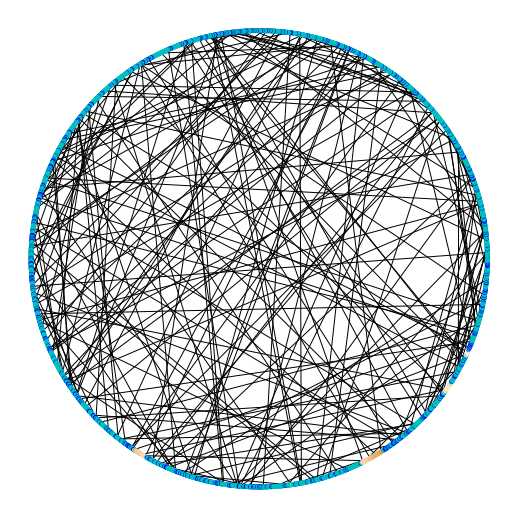

In [19]:
green_cmap = plt.get_cmap('Greens')
orange_cmap = plt.get_cmap('Oranges')

plt.figure(3,figsize=(7,7)) 
nx.draw_circular(g_max,
                node_size = 15,
                node_color = model.node_colors(g_max))

print("Light green: Recovered early. Dark green: Recovered late")
print("Light orange: Quarantined early. Dark orange: Quarantined late.")

In [20]:
#gradient = np.linspace(0,1,t)
#gradient = np.vstack((gradient, gradient))

#plt.imshow(gradient, aspect='auto', cmap=green_cmap)
#plt.imshow(gradient, aspect='auto', cmap=orange_cmap)

In [21]:
#history.keys()

(array([16.,  7.,  9.,  8.,  5.,  4.,  0.,  0.,  0.,  1.]),
 array([  1. ,  15.1,  29.2,  43.3,  57.4,  71.5,  85.6,  99.7, 113.8,
        127.9, 142. ]),
 <a list of 10 Patch objects>)

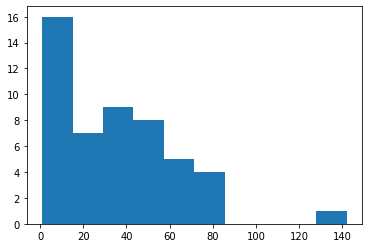

In [22]:
plt.hist([x[0] for x in records])

In [23]:
#plt.hist([node[1]['quarantined-at'] for node in g_live.nodes(data=True) if node[1]['quarantined']])

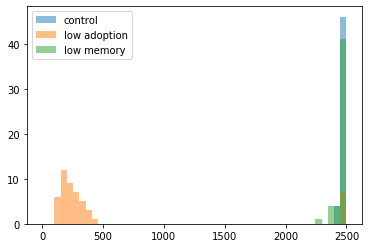

In [24]:
bins = np.linspace(0, len(g.nodes()), 50)

for case in results:
    plt.hist(
        [len(model.susceptible(r[1]))
         for r
         in results[case]],
        bins,
        alpha=.5,
        label=case)
    
plt.legend()